In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("Data_Processed/Recommendation.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97233 entries, 0 to 97232
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   State_Name          97233 non-null  object 
 1   Crop_Type           97233 non-null  object 
 2   Crop                97233 non-null  object 
 3   N                   97233 non-null  int64  
 4   P                   97233 non-null  int64  
 5   K                   97233 non-null  int64  
 6   pH                  97233 non-null  float64
 7   rainfall            97233 non-null  float64
 8   temperature         97233 non-null  float64
 9   Area_in_hectares    97233 non-null  float64
 10  Production_in_tons  97233 non-null  float64
dtypes: float64(5), int64(3), object(3)
memory usage: 8.2+ MB


In [3]:
df = df.drop(["Production_in_tons"],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97233 entries, 0 to 97232
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   State_Name        97233 non-null  object 
 1   Crop_Type         97233 non-null  object 
 2   Crop              97233 non-null  object 
 3   N                 97233 non-null  int64  
 4   P                 97233 non-null  int64  
 5   K                 97233 non-null  int64  
 6   pH                97233 non-null  float64
 7   rainfall          97233 non-null  float64
 8   temperature       97233 non-null  float64
 9   Area_in_hectares  97233 non-null  float64
dtypes: float64(4), int64(3), object(3)
memory usage: 7.4+ MB


In [4]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.preprocessing import LabelEncoder

C = ["State_Name","Crop_Type","Crop"]
le_D = {}
for i in C:
    le_D[i] = LabelEncoder()
    df[i] = le_D[i].fit_transform(df[i])

#bulk_scaler = StandardScaler()
bulk_scaler = MinMaxScaler()
features_to_scale = ["State_Name","Crop_Type","N","P","K","pH","rainfall","temperature","Area_in_hectares"]
#features_to_scale = ["N","P","K","pH","rainfall","temperature","Area_in_hectares"]
df[features_to_scale] = bulk_scaler.fit_transform(df[features_to_scale])

df.info()
df.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97233 entries, 0 to 97232
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   State_Name        97233 non-null  float64
 1   Crop_Type         97233 non-null  float64
 2   Crop              97233 non-null  int32  
 3   N                 97233 non-null  float64
 4   P                 97233 non-null  float64
 5   K                 97233 non-null  float64
 6   pH                97233 non-null  float64
 7   rainfall          97233 non-null  float64
 8   temperature       97233 non-null  float64
 9   Area_in_hectares  97233 non-null  float64
dtypes: float64(9), int32(1)
memory usage: 7.0 MB


State_Name             33
Crop_Type               4
Crop                   28
N                      14
P                       8
K                      12
pH                     82
rainfall              111
temperature           109
Area_in_hectares    26283
dtype: int64

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split,TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from collections import Counter
from sklearn.model_selection import KFold
data = df

In [6]:
class CropPredictor(nn.Module):
    def __init__(self, input_dim):
        super(CropPredictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 3)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [7]:
def train_model(model, train_features, train_target, test_features, test_target, num_epochs=3000, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(train_features)
        loss = criterion(outputs, train_target)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            test_outputs = model(test_features)
            test_loss = criterion(test_outputs, test_target)
            test_losses.append(test_loss.item())
        
        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

    # Plot epoch vs loss for train and test
    plt.figure(figsize=(10, 5))
    plt.plot(range(num_epochs), train_losses, label='Train Loss')
    plt.plot(range(num_epochs), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.show()

def evaluate_model(model, test_features, test_target):
    model.eval()
    criterion = nn.MSELoss()
    
    with torch.no_grad():
        predictions = model(test_features)
        mse = criterion(predictions, test_target).item()

    print(f'Mean Squared Error (MSE): {mse:.4f}')
    
    # Visualize predictions vs true values
    predictions = predictions.cpu().numpy()
    true_values = test_target.cpu().numpy()
    
    mse = mean_squared_error(true_values, predictions)
    mae = mean_absolute_error(true_values, predictions)
    r2 = r2_score(true_values, predictions)
    rmse = np.sqrt(mse)
    
    print(f'Mean Squared Error: {mse:.4f}')
    print(f'Mean Absolute Error: {mae:.4f}')
    print(f'R-squared: {r2:.4f}')
    print(f'Root Mean Squared Error: {rmse:.4f}')
    
    metrics = {'MSE': mse, 'MAE': mae, 'R-squared': r2, 'RMSE': rmse}
    metric_names = list(metrics.keys())
    metric_values = list(metrics.values())
    
    plt.figure(figsize=(10, 5))
    plt.bar(metric_names, metric_values, color=['blue', 'green', 'red', 'purple'])
    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.title('Evaluation Metrics for Regression')
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.plot(true_values[:, 0],label='True N')
    plt.plot(predictions[:, 0],label='Predicted N')
    plt.xlabel('Test cases')
    plt.ylabel('N values')
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.title('True vs Predicted N')
    
    plt.subplot(1, 3, 2)
    plt.plot(true_values[:, 1],label='True P')
    plt.plot(predictions[:, 1],label='Predicted P')
    plt.xlabel('Test cases')
    plt.ylabel('P values')
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.title('True vs Predicted P')
    
    plt.subplot(1, 3, 3)
    plt.plot(true_values[:, 2],label='True K')
    plt.plot(predictions[:, 2],label='Predicted K')
    plt.xlabel('Test cases')
    plt.ylabel('K values')
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.title('True vs Predicted K')
    
    plt.tight_layout()
    plt.show()

def evaluate_model_kfold(model_class, features, target, k=5, num_epochs=3000, learning_rate=0.001):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    all_predictions = []
    all_true_values = []
    mse_losses = []

    for fold, (train_idx, test_idx) in enumerate(kf.split(features)):
        train_features, test_features = features[train_idx], features[test_idx]
        train_target, test_target = target[train_idx], target[test_idx]

        model = model_class(train_features.shape[1]).to("cuda")
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Train the model for each fold
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(train_features)
            loss = criterion(outputs, train_target)
            loss.backward()
            optimizer.step()

        # Evaluate the model for each fold
        model.eval()
        with torch.no_grad():
            predictions = model(test_features)
            mse = criterion(predictions, test_target).item()
            mse_losses.append(mse)
            all_predictions.append(predictions.cpu().numpy())
            all_true_values.append(test_target.cpu().numpy())
        
        print(f'Fold {fold + 1}/{k}: Mean Squared Error (MSE): {mse:.4f}')

    avg_mse = np.mean(mse_losses)
    print(f'Average Mean Squared Error (MSE): {avg_mse:.4f}')

    all_predictions = np.vstack(all_predictions)
    all_true_values = np.vstack(all_true_values)

    mse = mean_squared_error(all_true_values, all_predictions)
    mae = mean_absolute_error(all_true_values, all_predictions)
    r2 = r2_score(all_true_values, all_predictions)
    rmse = np.sqrt(mse)

    print(f'Mean Squared Error: {mse:.4f}')
    print(f'Mean Absolute Error: {mae:.4f}')
    print(f'R-squared: {r2:.4f}')
    print(f'Root Mean Squared Error: {rmse:.4f}')
    
    metrics = {'MSE': mse, 'MAE': mae, 'R-squared': r2, 'RMSE': rmse}
    metric_names = list(metrics.keys())
    metric_values = list(metrics.values())
    
    plt.figure(figsize=(10, 5))
    plt.bar(metric_names, metric_values, color=['blue', 'green', 'red', 'purple'])
    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.title('Evaluation Metrics for Regression')
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.plot(all_true_values[:, 0], label='True N')
    plt.plot(all_predictions[:, 0], label='Predicted N')
    plt.xlabel('Test cases')
    plt.ylabel('N values')
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.title('True vs Predicted N')
    
    plt.subplot(1, 3, 2)
    plt.plot(all_true_values[:, 1], label='True P')
    plt.plot(all_predictions[:, 1], label='Predicted P')
    plt.xlabel('Test cases')
    plt.ylabel('P values')
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.title('True vs Predicted P')
    
    plt.subplot(1, 3, 3)
    plt.plot(all_true_values[:, 2], label='True K')
    plt.plot(all_predictions[:, 2], label='Predicted K')
    plt.xlabel('Test cases')
    plt.ylabel('K values')
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.title('True vs Predicted K')
    
    plt.tight_layout()
    plt.show()


In [8]:
features = data.drop(columns=['N','P','K']).values
target = data[['N','P','K']].values

features = torch.tensor(features, dtype=torch.float32).float().to("cuda")
target = torch.tensor(target, dtype=torch.float32).float().to("cuda")

train_features, test_features, train_target, test_target = train_test_split(features, target, test_size=0.2, random_state=42)

Epoch [100/2000], Train Loss: 0.0356, Test Loss: 0.0357
Epoch [200/2000], Train Loss: 0.0291, Test Loss: 0.0293
Epoch [300/2000], Train Loss: 0.0257, Test Loss: 0.0260
Epoch [400/2000], Train Loss: 0.0232, Test Loss: 0.0236
Epoch [500/2000], Train Loss: 0.0212, Test Loss: 0.0217
Epoch [600/2000], Train Loss: 0.0200, Test Loss: 0.0203
Epoch [700/2000], Train Loss: 0.0187, Test Loss: 0.0190
Epoch [800/2000], Train Loss: 0.0178, Test Loss: 0.0182
Epoch [900/2000], Train Loss: 0.0172, Test Loss: 0.0172
Epoch [1000/2000], Train Loss: 0.0165, Test Loss: 0.0169
Epoch [1100/2000], Train Loss: 0.0156, Test Loss: 0.0157
Epoch [1200/2000], Train Loss: 0.0149, Test Loss: 0.0153
Epoch [1300/2000], Train Loss: 0.0142, Test Loss: 0.0143
Epoch [1400/2000], Train Loss: 0.0154, Test Loss: 0.0151
Epoch [1500/2000], Train Loss: 0.0130, Test Loss: 0.0131
Epoch [1600/2000], Train Loss: 0.0126, Test Loss: 0.0128
Epoch [1700/2000], Train Loss: 0.0123, Test Loss: 0.0124
Epoch [1800/2000], Train Loss: 0.0120, T

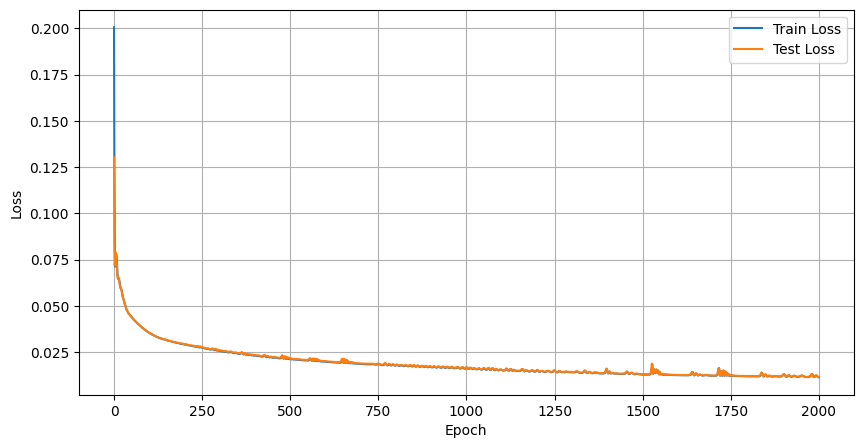

Mean Squared Error (MSE): 0.0117
Mean Squared Error: 0.0117
Mean Absolute Error: 0.0738
R-squared: 0.7705
Root Mean Squared Error: 0.1080


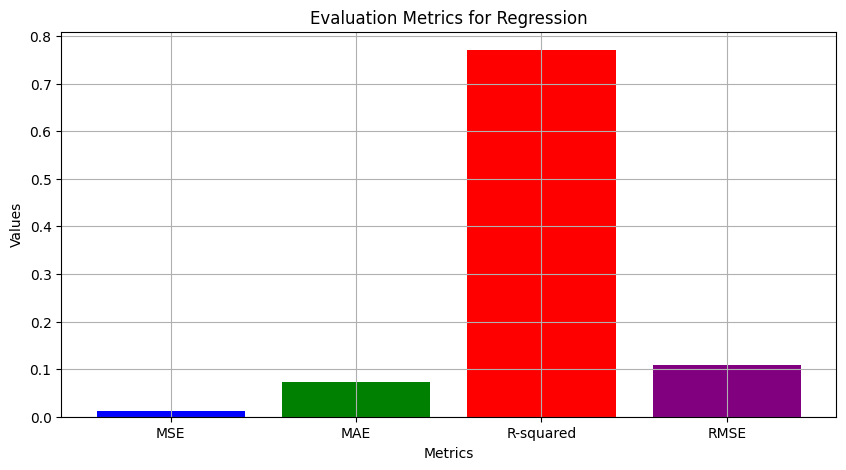

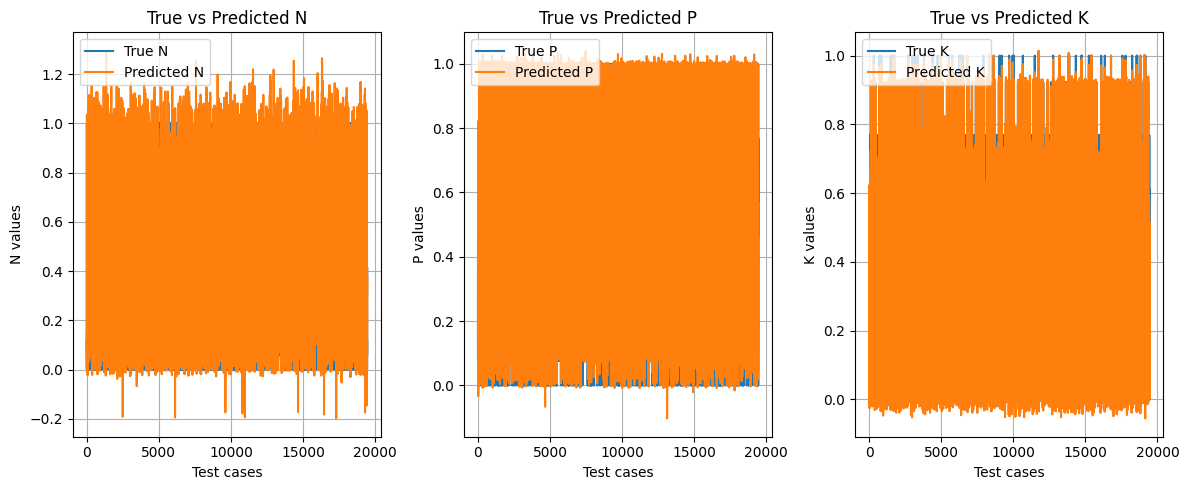

In [9]:
input_dim = train_features.shape[1]
model = CropPredictor(input_dim).to("cuda")

num_epochs = 2000
learning_rate = 0.001
train_model(model, train_features, train_target, test_features, test_target, num_epochs, learning_rate)
evaluate_model(model, test_features, test_target)
#evaluate_model_kfold(CropPredictor, features, target)

In [13]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('crop_predictor_experiment')
model = CropPredictor(input_dim).to("cuda")
writer.add_graph(model, train_features)
writer.close()